 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Theano-Implementation" data-toc-modified-id="Theano-Implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Theano Implementation</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Train-for-a-single-day" data-toc-modified-id="Train-for-a-single-day-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train for a single day</a></span></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Train-for-one-year" data-toc-modified-id="Train-for-one-year-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train for one year</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Keras-implementation" data-toc-modified-id="Keras-implementation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Keras implementation</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Predict-for-one-day" data-toc-modified-id="Predict-for-one-day-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Predict for one day</a></span></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Predict-for-one-year" data-toc-modified-id="Predict-for-one-year-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Predict for one year</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Fully-connected-model" data-toc-modified-id="Fully-connected-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fully connected model</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#For-one-day" data-toc-modified-id="For-one-day-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>For one day</a></span></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Train-for-the-entire-period" data-toc-modified-id="Train-for-the-entire-period-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train for the entire period</a></span></li></ul></li></ul></div>

# EMOS Network

In [109]:
# Imports
from importlib import reload
import emos_network_theano; reload(emos_network_theano)
from  emos_network_theano import EMOS_Network, crps_cost_function, crps_cost_function_var
import utils; reload(utils)
from utils import *
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Basic setup
# DATA_DIR = '/Users/stephanrasp/repositories/ppnn/data/'  # Mac
DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # LMU
fn = 'data_interpolated.nc'
window_size = 25
fclt = 48
utc = 0

## Theano Implementation

### Train for a single day

In [10]:
# Get the full dataset for 00UTC
tobs_full, tfc_full, dates = load_nc_data(DATA_DIR + fn, utc=utc)

In [30]:
# Just pick a day
date_idx = np.where(dates == datetime(2012, 1, 1, 0, 0))[0][0]
date_idx

1824

In [110]:
# Get the data slice for this particular date
tfc_mean_train, tfc_std_train, tobs_train, \
    tfc_mean_test, tfc_std_test, tobs_test = \
        get_train_test_data(tobs_full, tfc_full, date_idx, 
                            window_size, fclt, subtract_std_mean=False)

In [16]:
# Define some model parameters
lr = np.asarray(0.1, dtype='float32')   # The learning rate
early_stopping_delta = 1e-4   # How much the CRPS must improve before stopping
steps_max = 1000   # How many steps to fit at max

In [111]:
# Set up the theano model
model_theano = EMOS_Network()

In [112]:
# Train the model for some steps
model_theano.fit(tfc_mean_train, tfc_std_train, tobs_train, steps_max, 
          (tfc_mean_test, tfc_std_test, tobs_test), lr=lr, 
          early_stopping_delta=early_stopping_delta)
# Output is the training CRPS and the test CRPS

(array(0.8205566121028298), array(0.9479903863814672))

In [113]:
model_theano.predict(tfc_mean_test, tfc_std_test, tobs_test)

[array([  8.66367708,   5.98466973,   3.44301702,   9.08206283,
          6.59674019,   7.96345047,   3.88186502,   6.26595225,
          8.97892121,   4.37464365,   5.23401651,   8.89077757,
          1.41256966,   1.75850947,   3.44645773,   7.05724403,
          5.45259783,   4.84725578,   2.63203565,   6.41359141,
          7.77931293,   6.66171841,   5.53722766,   7.88054555,
          2.72823533,   2.41474505,   1.23052974,   3.78538734,
          8.5879984 ,   8.21610677,   8.96101297,   6.92143735,
          9.14808047,   6.06201562,   1.93987344,   2.30934027,
          1.87489522,   1.94297013,   2.10429008,   2.20850639,
          2.17783048,   5.14842843,   8.40931791,   9.26172018,
          8.50801657,   9.33090207,   4.77510669,   3.6883713 ,
          9.06613709,   9.81613312,   5.51083371,   6.31119675,
          8.1240294 ,   7.84710444,   7.23647628,   5.55858246,
          7.82553585,   4.9708052 ,   8.60577902,   6.53317832,
          2.36530845,   3.19670347,   3.

### Train for one year

In [295]:
# Get start and stop indices
date_idx_start = np.where(dates == datetime(2008, 1, 1, 0, 0))[0][0]
date_idx_stop = np.where(dates == datetime(2008, 12, 31, 0, 0))[0][0]
date_idx_start, date_idx_stop

(363, 728)

In [296]:
model_theano = EMOS_Network()

In [297]:
train_crps_list, valid_crps_list = loop_over_days(
    model_theano,
    tobs_full, 
    tfc_full, 
    date_idx_start, date_idx_stop, 
    window_size=window_size,
    fclt=fclt,     
    epochs_max=steps_max, 
    early_stopping_delta=early_stopping_delta, 
    lr=lr,
    model_type='EMOS_Network_theano')

400
500
600
700
Time: 23.44 s


In [298]:
# Let's see what the mean prediction CRPS is
np.mean(valid_crps_list)

1.0636229038525002

The standard EMOS global score (in `standard_postprocessing/emos_global.R`) is 1.0654. So we are doing a little better even, but this might just be chance.

## Keras implementation

First, let's build the same model in Keras.

In [80]:
# import the keras modules
# Note that the cost function only works with the theano backend
import keras
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

In [81]:
# Let's build the model with Keras' functional API
# This is quite a bit easier and shorter than in theano 
# But it did take me some time to figure out the cost function, etc.
def build_EMOS_Network_keras():
    mean_in = Input(shape=(1,))
    std_in = Input(shape=(1,))
    mean_out = Dense(1, activation='linear')(mean_in)
    std_out = Dense(1, activation='linear')(std_in)
    x = keras.layers.concatenate([mean_out, std_out], axis=1)
    return Model(inputs=[mean_in, std_in], outputs=x)

In [114]:
model_keras = build_EMOS_Network_keras()

In [115]:
model_keras.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_14 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 1)             2           input_13[0][0]                   
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 1)             2           input_14[0][0]                   
___________________________________________________________________________________________

In [116]:
# Compile the model with SGD initilalizer
opt = SGD(lr=0.1)  
model_keras.compile(optimizer=opt, loss=crps_cost_function, 
              metrics=[crps_cost_function])

In [95]:
model_keras.layers[3].get_weights()

[array([[ 0.69381654]], dtype=float32), array([ 0.], dtype=float32)]

### Predict for one day

In [117]:
# This way we have the gradient descent on the whole training set just as in theano
batch_size = tfc_mean_train.shape[0]   

In [118]:
h = model_keras.fit([tfc_mean_train, tfc_std_train], tobs_train, epochs=steps_max, batch_size=batch_size,
          validation_data=[[tfc_mean_test, tfc_std_test], tobs_test], verbose=1,
          callbacks=[EarlyStopping(monitor='loss', min_delta=early_stopping_delta,
                                  patience=2)])

Train on 12543 samples, validate on 494 samples
Epoch 1/1000
12543/12543 [==============================] - 0s - loss: 2.9835 - crps_cost_function: 2.9835 - val_loss: 4.1326 - val_crps_cost_function: 4.1326
Epoch 2/1000
12543/12543 [==============================] - 0s - loss: 2.8601 - crps_cost_function: 2.8601 - val_loss: 3.9962 - val_crps_cost_function: 3.9962
Epoch 3/1000
12543/12543 [==============================] - 0s - loss: 2.7526 - crps_cost_function: 2.7526 - val_loss: 3.8734 - val_crps_cost_function: 3.8734
Epoch 4/1000
12543/12543 [==============================] - 0s - loss: 2.6582 - crps_cost_function: 2.6582 - val_loss: 3.7617 - val_crps_cost_function: 3.7617
Epoch 5/1000
12543/12543 [==============================] - 0s - loss: 2.5744 - crps_cost_function: 2.5744 - val_loss: 3.6591 - val_crps_cost_function: 3.6591
Epoch 6/1000
12543/12543 [==============================] - 0s - loss: 2.4995 - crps_cost_function: 2.4995 - val_loss: 3.5639 - val_crps_cost_function: 3.563

12543/12543 [==============================] - 0s - loss: 1.1755 - crps_cost_function: 1.1755 - val_loss: 1.4530 - val_crps_cost_function: 1.4530
Epoch 52/1000
12543/12543 [==============================] - 0s - loss: 1.1598 - crps_cost_function: 1.1598 - val_loss: 1.4274 - val_crps_cost_function: 1.4274
Epoch 53/1000
12543/12543 [==============================] - 0s - loss: 1.1445 - crps_cost_function: 1.1445 - val_loss: 1.4025 - val_crps_cost_function: 1.4025
Epoch 54/1000
12543/12543 [==============================] - 0s - loss: 1.1296 - crps_cost_function: 1.1296 - val_loss: 1.3784 - val_crps_cost_function: 1.3784
Epoch 55/1000
12543/12543 [==============================] - 0s - loss: 1.1150 - crps_cost_function: 1.1150 - val_loss: 1.3550 - val_crps_cost_function: 1.3550
Epoch 56/1000
12543/12543 [==============================] - 0s - loss: 1.1009 - crps_cost_function: 1.1009 - val_loss: 1.3324 - val_crps_cost_function: 1.3324
Epoch 57/1000
12543/12543 [===========================

12543/12543 [==============================] - 0s - loss: 0.8328 - crps_cost_function: 0.8328 - val_loss: 0.9510 - val_crps_cost_function: 0.9510
Epoch 103/1000
12543/12543 [==============================] - 0s - loss: 0.8319 - crps_cost_function: 0.8319 - val_loss: 0.9506 - val_crps_cost_function: 0.9506
Epoch 104/1000
12543/12543 [==============================] - 0s - loss: 0.8312 - crps_cost_function: 0.8312 - val_loss: 0.9503 - val_crps_cost_function: 0.9503
Epoch 105/1000
12543/12543 [==============================] - 0s - loss: 0.8305 - crps_cost_function: 0.8305 - val_loss: 0.9501 - val_crps_cost_function: 0.9501
Epoch 106/1000
12543/12543 [==============================] - 0s - loss: 0.8298 - crps_cost_function: 0.8298 - val_loss: 0.9499 - val_crps_cost_function: 0.9499
Epoch 107/1000
12543/12543 [==============================] - 0s - loss: 0.8292 - crps_cost_function: 0.8292 - val_loss: 0.9498 - val_crps_cost_function: 0.9498
Epoch 108/1000
12543/12543 [=====================

In [124]:
model_keras.evaluate([tfc_mean_train, tfc_std_train], tobs_train, batch_size=64)

11200/12543 [=========================>....] - ETA: 0s

[0.82225062153951867, 0.82225062153951867]

In [119]:
model_keras.layers[3].get_weights()

[array([[-0.45263675]], dtype=float32), array([-0.35019872], dtype=float32)]

In [120]:
model_keras.layers[2].get_weights()

[array([[ 2.65799308]], dtype=float32), array([ 3.28904057], dtype=float32)]

In [40]:
model_keras.evaluate([tfc_mean_test, tfc_std_test], tobs_test, batch_size=64)

 64/494 [==>...........................] - ETA: 0s

[1.0061712487684644, 1.0061712487684644]

In [121]:
preds = model_keras.predict([tfc_mean_test, tfc_std_test])

In [122]:
preds[:5]

array([[ 8.75160599, -1.31993008],
       [ 6.03781986, -0.74646187],
       [ 3.46317196, -1.96104217],
       [ 9.17542267, -1.01966798],
       [ 6.65783596, -1.40188074]], dtype=float32)

In [123]:
tfc_mean_test[:5], tfc_std_test[:5]

(array([ 2.05514646,  1.03415596,  0.0655124 ,  2.21459651,  1.26742077], dtype=float32),
 array([ 2.14240527,  0.87545514,  3.55879951,  1.47904325,  2.323457  ], dtype=float32))

Se we get slightly better results than with the theano model above. This might be due to the differences in the early stopping algorithm.

In [252]:
len(h.history['loss'])

1000

In [253]:
# But I did notice something interesting looking at the history
valid_loss = h.history['val_loss']
train_loss = h.history['loss']

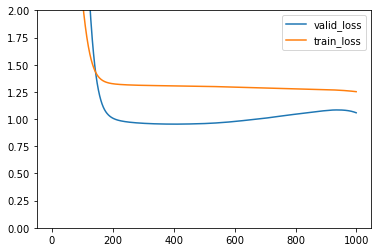

In [261]:
plt.plot(valid_loss, label='valid_loss')
plt.plot(train_loss, label='train_loss')
plt.legend()
plt.ylim(0, 2)
plt.show()

So this means we are overfitting a little. How could we avoid this. Let's pick a much longer training window.

In [255]:
# One year
tfc_mean_train, tfc_std_train, tobs_train, \
    tfc_mean_test, tfc_std_test, tobs_test = \
        get_train_test_data(tobs_full, tfc_full, date_idx, 
                            356, fclt)

In [256]:
batch_size = tfc_mean_train.shape[0]  

In [257]:
model = build_EMOS_Network_keras()
opt = SGD(lr=0.1)  
model.compile(optimizer=opt, loss=crps_cost_function, 
              metrics=[crps_cost_function])

In [258]:
h = model.fit([tfc_mean_train, tfc_std_train], tobs_train, epochs=steps_max, batch_size=batch_size,
          validation_data=[[tfc_mean_test, tfc_std_test], tobs_test], verbose=0,
          callbacks=[EarlyStopping(monitor='loss', min_delta=early_stopping_delta,
                                  patience=2)])

In [259]:
model.evaluate([tfc_mean_test, tfc_std_test], tobs_test, batch_size=64)

 64/495 [==>...........................] - ETA: 0s

[1.0561385891911841, 1.0561385891911841]

Doesn't seem to change much. Which means that either we have compensating errors or the seasonal information doesn't mean much. Here are some ideas:
- Create an actual validation data set from the training data and use it for early stopping

### Predict for one year

In [299]:
model_keras = build_EMOS_Network_keras()
opt = SGD(lr=0.1)  
model_keras.compile(optimizer=opt, loss=crps_cost_function, 
              metrics=[crps_cost_function])

In [300]:
train_crps_list, valid_crps_list = loop_over_days(
    model_keras,
    tobs_full, 
    tfc_full, 
    date_idx_start, date_idx_stop, 
    window_size=window_size,
    fclt=fclt,     
    epochs_max=steps_max, 
    early_stopping_delta=early_stopping_delta, 
    lr=lr,
    model_type='EMOS_Network_keras',
    verbose=0)

400
500
600
700
Time: 174.61 s


So the keras implementation is quite a bit slower than the pure theano version. Maybe this is due to the overhead with calling fit many many times. Which one to keep??

In [301]:
np.mean(valid_crps_list)

1.0640120236008785

In [292]:
train_crps_list

[1.0597541030445485,
 1.0666123334458606,
 1.061671031131364,
 1.0744410428044657,
 1.0880578167143964,
 1.0970980964955366]

## Fully connected model

### For one day

In [5]:
def build_fc_model():
    inp = Input(shape=(2,))
    x = Dense(2, activation='linear')(inp)
    return Model(inputs=inp, outputs=x)

In [125]:
fc_model = build_fc_model()

In [126]:
fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [127]:
from keras.optimizers import Adam
opt = Adam(lr=0.01)
fc_model.compile(optimizer=opt, loss=crps_cost_function, metrics=[crps_cost_function])

In [128]:
# Now we need to merge the input to a 2D vector
in_train = np.column_stack([tfc_mean_train, tfc_std_train])
in_test = np.column_stack([tfc_mean_test, tfc_std_test])
in_train.shape

(12543, 2)

In [129]:
batch_size = in_train.shape[0]  

In [59]:
# Normalize output
tobs_mean = np.mean(tobs_train)
tobs_std = np.std(tobs_train, ddof=1)
tobs_train_norm = (tobs_train - tobs_mean) / tobs_std
tobs_test_norm = (tobs_test - tobs_mean) / tobs_std

In [130]:
h = fc_model.fit(in_train, tobs_train, epochs=2000, batch_size=batch_size,
          validation_data=[in_test, tobs_test], verbose=1,
          callbacks=[EarlyStopping(monitor='loss', min_delta=1e-6,
                                  patience=2)])

Train on 12543 samples, validate on 494 samples
Epoch 1/2000
12543/12543 [==============================] - 0s - loss: 5.2644 - crps_cost_function: 5.2644 - val_loss: 7.6285 - val_crps_cost_function: 7.6285
Epoch 2/2000
12543/12543 [==============================] - 0s - loss: 5.2173 - crps_cost_function: 5.2173 - val_loss: 7.5632 - val_crps_cost_function: 7.5632
Epoch 3/2000
12543/12543 [==============================] - 0s - loss: 5.1703 - crps_cost_function: 5.1703 - val_loss: 7.4981 - val_crps_cost_function: 7.4981
Epoch 4/2000
12543/12543 [==============================] - 0s - loss: 5.1234 - crps_cost_function: 5.1234 - val_loss: 7.4332 - val_crps_cost_function: 7.4332
Epoch 5/2000
12543/12543 [==============================] - 0s - loss: 5.0767 - crps_cost_function: 5.0767 - val_loss: 7.3684 - val_crps_cost_function: 7.3684
Epoch 6/2000
12543/12543 [==============================] - 0s - loss: 5.0301 - crps_cost_function: 5.0301 - val_loss: 7.3038 - val_crps_cost_function: 7.303

12543/12543 [==============================] - 0s - loss: 3.2692 - crps_cost_function: 3.2692 - val_loss: 4.8113 - val_crps_cost_function: 4.8113
Epoch 52/2000
12543/12543 [==============================] - 0s - loss: 3.2401 - crps_cost_function: 3.2401 - val_loss: 4.7686 - val_crps_cost_function: 4.7686
Epoch 53/2000
12543/12543 [==============================] - 0s - loss: 3.2115 - crps_cost_function: 3.2115 - val_loss: 4.7265 - val_crps_cost_function: 4.7265
Epoch 54/2000
12543/12543 [==============================] - 0s - loss: 3.1834 - crps_cost_function: 3.1834 - val_loss: 4.6850 - val_crps_cost_function: 4.6850
Epoch 55/2000
12543/12543 [==============================] - 0s - loss: 3.1557 - crps_cost_function: 3.1557 - val_loss: 4.6440 - val_crps_cost_function: 4.6440
Epoch 56/2000
12543/12543 [==============================] - 0s - loss: 3.1284 - crps_cost_function: 3.1284 - val_loss: 4.6037 - val_crps_cost_function: 4.6037
Epoch 57/2000
12543/12543 [===========================

12543/12543 [==============================] - 0s - loss: 2.2602 - crps_cost_function: 2.2602 - val_loss: 3.2722 - val_crps_cost_function: 3.2722
Epoch 103/2000
12543/12543 [==============================] - 0s - loss: 2.2474 - crps_cost_function: 2.2474 - val_loss: 3.2519 - val_crps_cost_function: 3.2519
Epoch 104/2000
12543/12543 [==============================] - 0s - loss: 2.2348 - crps_cost_function: 2.2348 - val_loss: 3.2318 - val_crps_cost_function: 3.2318
Epoch 105/2000
12543/12543 [==============================] - 0s - loss: 2.2223 - crps_cost_function: 2.2223 - val_loss: 3.2121 - val_crps_cost_function: 3.2121
Epoch 106/2000
12543/12543 [==============================] - 0s - loss: 2.2101 - crps_cost_function: 2.2101 - val_loss: 3.1926 - val_crps_cost_function: 3.1926
Epoch 107/2000
12543/12543 [==============================] - 0s - loss: 2.1979 - crps_cost_function: 2.1979 - val_loss: 3.1733 - val_crps_cost_function: 3.1733
Epoch 108/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 1.7748 - crps_cost_function: 1.7748 - val_loss: 2.4935 - val_crps_cost_function: 2.4935
Epoch 153/2000
12543/12543 [==============================] - 0s - loss: 1.7674 - crps_cost_function: 1.7674 - val_loss: 2.4815 - val_crps_cost_function: 2.4815
Epoch 154/2000
12543/12543 [==============================] - 0s - loss: 1.7600 - crps_cost_function: 1.7600 - val_loss: 2.4696 - val_crps_cost_function: 2.4696
Epoch 155/2000
12543/12543 [==============================] - 0s - loss: 1.7527 - crps_cost_function: 1.7527 - val_loss: 2.4578 - val_crps_cost_function: 2.4578
Epoch 156/2000
12543/12543 [==============================] - 0s - loss: 1.7455 - crps_cost_function: 1.7455 - val_loss: 2.4461 - val_crps_cost_function: 2.4461
Epoch 157/2000
12543/12543 [==============================] - 0s - loss: 1.7383 - crps_cost_function: 1.7383 - val_loss: 2.4344 - val_crps_cost_function: 2.4344
Epoch 158/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 1.4633 - crps_cost_function: 1.4633 - val_loss: 1.9896 - val_crps_cost_function: 1.9896
Epoch 203/2000
12543/12543 [==============================] - 0s - loss: 1.4581 - crps_cost_function: 1.4581 - val_loss: 1.9811 - val_crps_cost_function: 1.9811
Epoch 204/2000
12543/12543 [==============================] - 0s - loss: 1.4529 - crps_cost_function: 1.4529 - val_loss: 1.9727 - val_crps_cost_function: 1.9727
Epoch 205/2000
12543/12543 [==============================] - 0s - loss: 1.4478 - crps_cost_function: 1.4478 - val_loss: 1.9643 - val_crps_cost_function: 1.9643
Epoch 206/2000
12543/12543 [==============================] - 0s - loss: 1.4426 - crps_cost_function: 1.4426 - val_loss: 1.9560 - val_crps_cost_function: 1.9560
Epoch 207/2000
12543/12543 [==============================] - 0s - loss: 1.4375 - crps_cost_function: 1.4375 - val_loss: 1.9478 - val_crps_cost_function: 1.9478
Epoch 208/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 1.2365 - crps_cost_function: 1.2365 - val_loss: 1.6232 - val_crps_cost_function: 1.6232
Epoch 253/2000
12543/12543 [==============================] - 0s - loss: 1.2327 - crps_cost_function: 1.2327 - val_loss: 1.6170 - val_crps_cost_function: 1.6170
Epoch 254/2000
12543/12543 [==============================] - 0s - loss: 1.2288 - crps_cost_function: 1.2288 - val_loss: 1.6108 - val_crps_cost_function: 1.6108
Epoch 255/2000
12543/12543 [==============================] - 0s - loss: 1.2250 - crps_cost_function: 1.2250 - val_loss: 1.6047 - val_crps_cost_function: 1.6047
Epoch 256/2000
12543/12543 [==============================] - 0s - loss: 1.2212 - crps_cost_function: 1.2212 - val_loss: 1.5986 - val_crps_cost_function: 1.5986
Epoch 257/2000
12543/12543 [==============================] - 0s - loss: 1.2174 - crps_cost_function: 1.2174 - val_loss: 1.5925 - val_crps_cost_function: 1.5925
Epoch 258/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 1.0715 - crps_cost_function: 1.0715 - val_loss: 1.3633 - val_crps_cost_function: 1.3633
Epoch 303/2000
12543/12543 [==============================] - 0s - loss: 1.0687 - crps_cost_function: 1.0687 - val_loss: 1.3591 - val_crps_cost_function: 1.3591
Epoch 304/2000
12543/12543 [==============================] - 0s - loss: 1.0660 - crps_cost_function: 1.0660 - val_loss: 1.3551 - val_crps_cost_function: 1.3551
Epoch 305/2000
12543/12543 [==============================] - 0s - loss: 1.0633 - crps_cost_function: 1.0633 - val_loss: 1.3510 - val_crps_cost_function: 1.3510
Epoch 306/2000
12543/12543 [==============================] - 0s - loss: 1.0606 - crps_cost_function: 1.0606 - val_loss: 1.3470 - val_crps_cost_function: 1.3470
Epoch 307/2000
12543/12543 [==============================] - 0s - loss: 1.0580 - crps_cost_function: 1.0580 - val_loss: 1.3430 - val_crps_cost_function: 1.3430
Epoch 308/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.9552 - crps_cost_function: 0.9552 - val_loss: 1.2067 - val_crps_cost_function: 1.2067
Epoch 353/2000
12543/12543 [==============================] - 0s - loss: 0.9532 - crps_cost_function: 0.9532 - val_loss: 1.2046 - val_crps_cost_function: 1.2046
Epoch 354/2000
12543/12543 [==============================] - 0s - loss: 0.9512 - crps_cost_function: 0.9512 - val_loss: 1.2025 - val_crps_cost_function: 1.2025
Epoch 355/2000
12543/12543 [==============================] - 0s - loss: 0.9493 - crps_cost_function: 0.9493 - val_loss: 1.2004 - val_crps_cost_function: 1.2004
Epoch 356/2000
12543/12543 [==============================] - 0s - loss: 0.9473 - crps_cost_function: 0.9473 - val_loss: 1.1984 - val_crps_cost_function: 1.1984
Epoch 357/2000
12543/12543 [==============================] - 0s - loss: 0.9454 - crps_cost_function: 0.9454 - val_loss: 1.1964 - val_crps_cost_function: 1.1964
Epoch 358/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8787 - crps_cost_function: 0.8787 - val_loss: 1.1454 - val_crps_cost_function: 1.1454
Epoch 403/2000
12543/12543 [==============================] - 0s - loss: 0.8778 - crps_cost_function: 0.8778 - val_loss: 1.1450 - val_crps_cost_function: 1.1450
Epoch 404/2000
12543/12543 [==============================] - 0s - loss: 0.8769 - crps_cost_function: 0.8769 - val_loss: 1.1446 - val_crps_cost_function: 1.1446
Epoch 405/2000
12543/12543 [==============================] - 0s - loss: 0.8760 - crps_cost_function: 0.8760 - val_loss: 1.1443 - val_crps_cost_function: 1.1443
Epoch 406/2000
12543/12543 [==============================] - 0s - loss: 0.8751 - crps_cost_function: 0.8751 - val_loss: 1.1440 - val_crps_cost_function: 1.1440
Epoch 407/2000
12543/12543 [==============================] - 0s - loss: 0.8743 - crps_cost_function: 0.8743 - val_loss: 1.1437 - val_crps_cost_function: 1.1437
Epoch 408/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8510 - crps_cost_function: 0.8510 - val_loss: 1.1407 - val_crps_cost_function: 1.1407
Epoch 453/2000
12543/12543 [==============================] - 0s - loss: 0.8507 - crps_cost_function: 0.8507 - val_loss: 1.1406 - val_crps_cost_function: 1.1406
Epoch 454/2000
12543/12543 [==============================] - 0s - loss: 0.8505 - crps_cost_function: 0.8505 - val_loss: 1.1406 - val_crps_cost_function: 1.1406
Epoch 455/2000
12543/12543 [==============================] - 0s - loss: 0.8502 - crps_cost_function: 0.8502 - val_loss: 1.1406 - val_crps_cost_function: 1.1406
Epoch 456/2000
12543/12543 [==============================] - 0s - loss: 0.8499 - crps_cost_function: 0.8499 - val_loss: 1.1405 - val_crps_cost_function: 1.1405
Epoch 457/2000
12543/12543 [==============================] - 0s - loss: 0.8496 - crps_cost_function: 0.8496 - val_loss: 1.1405 - val_crps_cost_function: 1.1405
Epoch 458/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8418 - crps_cost_function: 0.8418 - val_loss: 1.1360 - val_crps_cost_function: 1.1360
Epoch 503/2000
12543/12543 [==============================] - 0s - loss: 0.8416 - crps_cost_function: 0.8416 - val_loss: 1.1358 - val_crps_cost_function: 1.1358
Epoch 504/2000
12543/12543 [==============================] - 0s - loss: 0.8415 - crps_cost_function: 0.8415 - val_loss: 1.1357 - val_crps_cost_function: 1.1357
Epoch 505/2000
12543/12543 [==============================] - 0s - loss: 0.8414 - crps_cost_function: 0.8414 - val_loss: 1.1356 - val_crps_cost_function: 1.1356
Epoch 506/2000
12543/12543 [==============================] - 0s - loss: 0.8413 - crps_cost_function: 0.8413 - val_loss: 1.1354 - val_crps_cost_function: 1.1354
Epoch 507/2000
12543/12543 [==============================] - 0s - loss: 0.8412 - crps_cost_function: 0.8412 - val_loss: 1.1353 - val_crps_cost_function: 1.1353
Epoch 508/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8371 - crps_cost_function: 0.8371 - val_loss: 1.1279 - val_crps_cost_function: 1.1279
Epoch 553/2000
12543/12543 [==============================] - 0s - loss: 0.8370 - crps_cost_function: 0.8370 - val_loss: 1.1277 - val_crps_cost_function: 1.1277
Epoch 554/2000
12543/12543 [==============================] - 0s - loss: 0.8370 - crps_cost_function: 0.8370 - val_loss: 1.1275 - val_crps_cost_function: 1.1275
Epoch 555/2000
12543/12543 [==============================] - 0s - loss: 0.8369 - crps_cost_function: 0.8369 - val_loss: 1.1274 - val_crps_cost_function: 1.1274
Epoch 556/2000
12543/12543 [==============================] - 0s - loss: 0.8368 - crps_cost_function: 0.8368 - val_loss: 1.1272 - val_crps_cost_function: 1.1272
Epoch 557/2000
12543/12543 [==============================] - 0s - loss: 0.8367 - crps_cost_function: 0.8367 - val_loss: 1.1270 - val_crps_cost_function: 1.1270
Epoch 558/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8336 - crps_cost_function: 0.8336 - val_loss: 1.1188 - val_crps_cost_function: 1.1188
Epoch 603/2000
12543/12543 [==============================] - 0s - loss: 0.8335 - crps_cost_function: 0.8335 - val_loss: 1.1186 - val_crps_cost_function: 1.1186
Epoch 604/2000
12543/12543 [==============================] - 0s - loss: 0.8334 - crps_cost_function: 0.8334 - val_loss: 1.1184 - val_crps_cost_function: 1.1184
Epoch 605/2000
12543/12543 [==============================] - 0s - loss: 0.8334 - crps_cost_function: 0.8334 - val_loss: 1.1182 - val_crps_cost_function: 1.1182
Epoch 606/2000
12543/12543 [==============================] - 0s - loss: 0.8333 - crps_cost_function: 0.8333 - val_loss: 1.1180 - val_crps_cost_function: 1.1180
Epoch 607/2000
12543/12543 [==============================] - 0s - loss: 0.8332 - crps_cost_function: 0.8332 - val_loss: 1.1178 - val_crps_cost_function: 1.1178
Epoch 608/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8305 - crps_cost_function: 0.8305 - val_loss: 1.1094 - val_crps_cost_function: 1.1094
Epoch 653/2000
12543/12543 [==============================] - 0s - loss: 0.8304 - crps_cost_function: 0.8304 - val_loss: 1.1092 - val_crps_cost_function: 1.1092
Epoch 654/2000
12543/12543 [==============================] - 0s - loss: 0.8304 - crps_cost_function: 0.8304 - val_loss: 1.1090 - val_crps_cost_function: 1.1090
Epoch 655/2000
12543/12543 [==============================] - 0s - loss: 0.8303 - crps_cost_function: 0.8303 - val_loss: 1.1088 - val_crps_cost_function: 1.1088
Epoch 656/2000
12543/12543 [==============================] - 0s - loss: 0.8303 - crps_cost_function: 0.8303 - val_loss: 1.1087 - val_crps_cost_function: 1.1087
Epoch 657/2000
12543/12543 [==============================] - 0s - loss: 0.8302 - crps_cost_function: 0.8302 - val_loss: 1.1085 - val_crps_cost_function: 1.1085
Epoch 658/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8278 - crps_cost_function: 0.8278 - val_loss: 1.1003 - val_crps_cost_function: 1.1003
Epoch 703/2000
12543/12543 [==============================] - 0s - loss: 0.8277 - crps_cost_function: 0.8277 - val_loss: 1.1001 - val_crps_cost_function: 1.1001
Epoch 704/2000
12543/12543 [==============================] - 0s - loss: 0.8277 - crps_cost_function: 0.8277 - val_loss: 1.0999 - val_crps_cost_function: 1.0999
Epoch 705/2000
12543/12543 [==============================] - 0s - loss: 0.8276 - crps_cost_function: 0.8276 - val_loss: 1.0997 - val_crps_cost_function: 1.0997
Epoch 706/2000
12543/12543 [==============================] - 0s - loss: 0.8276 - crps_cost_function: 0.8276 - val_loss: 1.0995 - val_crps_cost_function: 1.0995
Epoch 707/2000
12543/12543 [==============================] - 0s - loss: 0.8275 - crps_cost_function: 0.8275 - val_loss: 1.0994 - val_crps_cost_function: 1.0994
Epoch 708/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8254 - crps_cost_function: 0.8254 - val_loss: 1.0915 - val_crps_cost_function: 1.0915
Epoch 753/2000
12543/12543 [==============================] - 0s - loss: 0.8254 - crps_cost_function: 0.8254 - val_loss: 1.0913 - val_crps_cost_function: 1.0913
Epoch 754/2000
12543/12543 [==============================] - 0s - loss: 0.8253 - crps_cost_function: 0.8253 - val_loss: 1.0912 - val_crps_cost_function: 1.0912
Epoch 755/2000
12543/12543 [==============================] - 0s - loss: 0.8253 - crps_cost_function: 0.8253 - val_loss: 1.0910 - val_crps_cost_function: 1.0910
Epoch 756/2000
12543/12543 [==============================] - 0s - loss: 0.8253 - crps_cost_function: 0.8253 - val_loss: 1.0908 - val_crps_cost_function: 1.0908
Epoch 757/2000
12543/12543 [==============================] - 0s - loss: 0.8252 - crps_cost_function: 0.8252 - val_loss: 1.0907 - val_crps_cost_function: 1.0907
Epoch 758/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8234 - crps_cost_function: 0.8234 - val_loss: 1.0833 - val_crps_cost_function: 1.0833
Epoch 803/2000
12543/12543 [==============================] - 0s - loss: 0.8234 - crps_cost_function: 0.8234 - val_loss: 1.0831 - val_crps_cost_function: 1.0831
Epoch 804/2000
12543/12543 [==============================] - 0s - loss: 0.8233 - crps_cost_function: 0.8233 - val_loss: 1.0830 - val_crps_cost_function: 1.0830
Epoch 805/2000
12543/12543 [==============================] - 0s - loss: 0.8233 - crps_cost_function: 0.8233 - val_loss: 1.0828 - val_crps_cost_function: 1.0828
Epoch 806/2000
12543/12543 [==============================] - 0s - loss: 0.8232 - crps_cost_function: 0.8232 - val_loss: 1.0827 - val_crps_cost_function: 1.0827
Epoch 807/2000
12543/12543 [==============================] - 0s - loss: 0.8232 - crps_cost_function: 0.8232 - val_loss: 1.0825 - val_crps_cost_function: 1.0825
Epoch 808/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8217 - crps_cost_function: 0.8217 - val_loss: 1.0756 - val_crps_cost_function: 1.0756
Epoch 853/2000
12543/12543 [==============================] - 0s - loss: 0.8216 - crps_cost_function: 0.8216 - val_loss: 1.0754 - val_crps_cost_function: 1.0754
Epoch 854/2000
12543/12543 [==============================] - 0s - loss: 0.8216 - crps_cost_function: 0.8216 - val_loss: 1.0753 - val_crps_cost_function: 1.0753
Epoch 855/2000
12543/12543 [==============================] - 0s - loss: 0.8216 - crps_cost_function: 0.8216 - val_loss: 1.0752 - val_crps_cost_function: 1.0752
Epoch 856/2000
12543/12543 [==============================] - 0s - loss: 0.8215 - crps_cost_function: 0.8215 - val_loss: 1.0750 - val_crps_cost_function: 1.0750
Epoch 857/2000
12543/12543 [==============================] - 0s - loss: 0.8215 - crps_cost_function: 0.8215 - val_loss: 1.0749 - val_crps_cost_function: 1.0749
Epoch 858/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8202 - crps_cost_function: 0.8202 - val_loss: 1.0685 - val_crps_cost_function: 1.0685
Epoch 903/2000
12543/12543 [==============================] - 0s - loss: 0.8202 - crps_cost_function: 0.8202 - val_loss: 1.0683 - val_crps_cost_function: 1.0683
Epoch 904/2000
12543/12543 [==============================] - 0s - loss: 0.8202 - crps_cost_function: 0.8202 - val_loss: 1.0682 - val_crps_cost_function: 1.0682
Epoch 905/2000
12543/12543 [==============================] - 0s - loss: 0.8201 - crps_cost_function: 0.8201 - val_loss: 1.0680 - val_crps_cost_function: 1.0680
Epoch 906/2000
12543/12543 [==============================] - 0s - loss: 0.8201 - crps_cost_function: 0.8201 - val_loss: 1.0679 - val_crps_cost_function: 1.0679
Epoch 907/2000
12543/12543 [==============================] - 0s - loss: 0.8201 - crps_cost_function: 0.8201 - val_loss: 1.0678 - val_crps_cost_function: 1.0678
Epoch 908/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8190 - crps_cost_function: 0.8190 - val_loss: 1.0619 - val_crps_cost_function: 1.0619
Epoch 953/2000
12543/12543 [==============================] - 0s - loss: 0.8190 - crps_cost_function: 0.8190 - val_loss: 1.0618 - val_crps_cost_function: 1.0618
Epoch 954/2000
12543/12543 [==============================] - 0s - loss: 0.8190 - crps_cost_function: 0.8190 - val_loss: 1.0616 - val_crps_cost_function: 1.0616
Epoch 955/2000
12543/12543 [==============================] - 0s - loss: 0.8189 - crps_cost_function: 0.8189 - val_loss: 1.0615 - val_crps_cost_function: 1.0615
Epoch 956/2000
12543/12543 [==============================] - 0s - loss: 0.8189 - crps_cost_function: 0.8189 - val_loss: 1.0614 - val_crps_cost_function: 1.0614
Epoch 957/2000
12543/12543 [==============================] - 0s - loss: 0.8189 - crps_cost_function: 0.8189 - val_loss: 1.0613 - val_crps_cost_function: 1.0613
Epoch 958/2000
12543/12543 [=====================

12543/12543 [==============================] - 0s - loss: 0.8180 - crps_cost_function: 0.8180 - val_loss: 1.0559 - val_crps_cost_function: 1.0559
Epoch 1003/2000
12543/12543 [==============================] - 0s - loss: 0.8180 - crps_cost_function: 0.8180 - val_loss: 1.0557 - val_crps_cost_function: 1.0557
Epoch 1004/2000
12543/12543 [==============================] - 0s - loss: 0.8180 - crps_cost_function: 0.8180 - val_loss: 1.0556 - val_crps_cost_function: 1.0556
Epoch 1005/2000
12543/12543 [==============================] - 0s - loss: 0.8180 - crps_cost_function: 0.8180 - val_loss: 1.0555 - val_crps_cost_function: 1.0555
Epoch 1006/2000
12543/12543 [==============================] - 0s - loss: 0.8179 - crps_cost_function: 0.8179 - val_loss: 1.0554 - val_crps_cost_function: 1.0554
Epoch 1007/2000
12543/12543 [==============================] - 0s - loss: 0.8179 - crps_cost_function: 0.8179 - val_loss: 1.0553 - val_crps_cost_function: 1.0553
Epoch 1008/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8172 - crps_cost_function: 0.8172 - val_loss: 1.0504 - val_crps_cost_function: 1.0504
Epoch 1053/2000
12543/12543 [==============================] - 0s - loss: 0.8172 - crps_cost_function: 0.8172 - val_loss: 1.0503 - val_crps_cost_function: 1.0503
Epoch 1054/2000
12543/12543 [==============================] - 0s - loss: 0.8172 - crps_cost_function: 0.8172 - val_loss: 1.0501 - val_crps_cost_function: 1.0501
Epoch 1055/2000
12543/12543 [==============================] - 0s - loss: 0.8172 - crps_cost_function: 0.8172 - val_loss: 1.0500 - val_crps_cost_function: 1.0500
Epoch 1056/2000
12543/12543 [==============================] - 0s - loss: 0.8171 - crps_cost_function: 0.8171 - val_loss: 1.0499 - val_crps_cost_function: 1.0499
Epoch 1057/2000
12543/12543 [==============================] - 0s - loss: 0.8171 - crps_cost_function: 0.8171 - val_loss: 1.0498 - val_crps_cost_function: 1.0498
Epoch 1058/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8166 - crps_cost_function: 0.8166 - val_loss: 1.0454 - val_crps_cost_function: 1.0454
Epoch 1103/2000
12543/12543 [==============================] - 0s - loss: 0.8165 - crps_cost_function: 0.8165 - val_loss: 1.0453 - val_crps_cost_function: 1.0453
Epoch 1104/2000
12543/12543 [==============================] - 0s - loss: 0.8165 - crps_cost_function: 0.8165 - val_loss: 1.0452 - val_crps_cost_function: 1.0452
Epoch 1105/2000
12543/12543 [==============================] - 0s - loss: 0.8165 - crps_cost_function: 0.8165 - val_loss: 1.0451 - val_crps_cost_function: 1.0451
Epoch 1106/2000
12543/12543 [==============================] - 0s - loss: 0.8165 - crps_cost_function: 0.8165 - val_loss: 1.0450 - val_crps_cost_function: 1.0450
Epoch 1107/2000
12543/12543 [==============================] - 0s - loss: 0.8165 - crps_cost_function: 0.8165 - val_loss: 1.0449 - val_crps_cost_function: 1.0449
Epoch 1108/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8161 - crps_cost_function: 0.8161 - val_loss: 1.0409 - val_crps_cost_function: 1.0409
Epoch 1153/2000
12543/12543 [==============================] - 0s - loss: 0.8160 - crps_cost_function: 0.8160 - val_loss: 1.0408 - val_crps_cost_function: 1.0408
Epoch 1154/2000
12543/12543 [==============================] - 0s - loss: 0.8160 - crps_cost_function: 0.8160 - val_loss: 1.0407 - val_crps_cost_function: 1.0407
Epoch 1155/2000
12543/12543 [==============================] - 0s - loss: 0.8160 - crps_cost_function: 0.8160 - val_loss: 1.0406 - val_crps_cost_function: 1.0406
Epoch 1156/2000
12543/12543 [==============================] - 0s - loss: 0.8160 - crps_cost_function: 0.8160 - val_loss: 1.0406 - val_crps_cost_function: 1.0406
Epoch 1157/2000
12543/12543 [==============================] - 0s - loss: 0.8160 - crps_cost_function: 0.8160 - val_loss: 1.0405 - val_crps_cost_function: 1.0405
Epoch 1158/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8157 - crps_cost_function: 0.8157 - val_loss: 1.0369 - val_crps_cost_function: 1.0369
Epoch 1203/2000
12543/12543 [==============================] - 0s - loss: 0.8156 - crps_cost_function: 0.8156 - val_loss: 1.0368 - val_crps_cost_function: 1.0368
Epoch 1204/2000
12543/12543 [==============================] - 0s - loss: 0.8156 - crps_cost_function: 0.8156 - val_loss: 1.0367 - val_crps_cost_function: 1.0367
Epoch 1205/2000
12543/12543 [==============================] - 0s - loss: 0.8156 - crps_cost_function: 0.8156 - val_loss: 1.0366 - val_crps_cost_function: 1.0366
Epoch 1206/2000
12543/12543 [==============================] - 0s - loss: 0.8156 - crps_cost_function: 0.8156 - val_loss: 1.0366 - val_crps_cost_function: 1.0366
Epoch 1207/2000
12543/12543 [==============================] - 0s - loss: 0.8156 - crps_cost_function: 0.8156 - val_loss: 1.0365 - val_crps_cost_function: 1.0365
Epoch 1208/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8153 - crps_cost_function: 0.8153 - val_loss: 1.0333 - val_crps_cost_function: 1.0333
Epoch 1253/2000
12543/12543 [==============================] - 0s - loss: 0.8153 - crps_cost_function: 0.8153 - val_loss: 1.0332 - val_crps_cost_function: 1.0332
Epoch 1254/2000
12543/12543 [==============================] - 0s - loss: 0.8153 - crps_cost_function: 0.8153 - val_loss: 1.0331 - val_crps_cost_function: 1.0331
Epoch 1255/2000
12543/12543 [==============================] - 0s - loss: 0.8153 - crps_cost_function: 0.8153 - val_loss: 1.0331 - val_crps_cost_function: 1.0331
Epoch 1256/2000
12543/12543 [==============================] - 0s - loss: 0.8153 - crps_cost_function: 0.8153 - val_loss: 1.0330 - val_crps_cost_function: 1.0330
Epoch 1257/2000
12543/12543 [==============================] - 0s - loss: 0.8153 - crps_cost_function: 0.8153 - val_loss: 1.0329 - val_crps_cost_function: 1.0329
Epoch 1258/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8151 - crps_cost_function: 0.8151 - val_loss: 1.0301 - val_crps_cost_function: 1.0301
Epoch 1303/2000
12543/12543 [==============================] - 0s - loss: 0.8151 - crps_cost_function: 0.8151 - val_loss: 1.0300 - val_crps_cost_function: 1.0300
Epoch 1304/2000
12543/12543 [==============================] - 0s - loss: 0.8151 - crps_cost_function: 0.8151 - val_loss: 1.0300 - val_crps_cost_function: 1.0300
Epoch 1305/2000
12543/12543 [==============================] - 0s - loss: 0.8151 - crps_cost_function: 0.8151 - val_loss: 1.0299 - val_crps_cost_function: 1.0299
Epoch 1306/2000
12543/12543 [==============================] - 0s - loss: 0.8151 - crps_cost_function: 0.8151 - val_loss: 1.0299 - val_crps_cost_function: 1.0299
Epoch 1307/2000
12543/12543 [==============================] - 0s - loss: 0.8151 - crps_cost_function: 0.8151 - val_loss: 1.0298 - val_crps_cost_function: 1.0298
Epoch 1308/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8149 - crps_cost_function: 0.8149 - val_loss: 1.0273 - val_crps_cost_function: 1.0273
Epoch 1353/2000
12543/12543 [==============================] - 0s - loss: 0.8149 - crps_cost_function: 0.8149 - val_loss: 1.0272 - val_crps_cost_function: 1.0272
Epoch 1354/2000
12543/12543 [==============================] - 0s - loss: 0.8149 - crps_cost_function: 0.8149 - val_loss: 1.0272 - val_crps_cost_function: 1.0272
Epoch 1355/2000
12543/12543 [==============================] - 0s - loss: 0.8149 - crps_cost_function: 0.8149 - val_loss: 1.0271 - val_crps_cost_function: 1.0271
Epoch 1356/2000
12543/12543 [==============================] - 0s - loss: 0.8149 - crps_cost_function: 0.8149 - val_loss: 1.0271 - val_crps_cost_function: 1.0271
Epoch 1357/2000
12543/12543 [==============================] - 0s - loss: 0.8149 - crps_cost_function: 0.8149 - val_loss: 1.0270 - val_crps_cost_function: 1.0270
Epoch 1358/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8148 - crps_cost_function: 0.8148 - val_loss: 1.0248 - val_crps_cost_function: 1.0248
Epoch 1403/2000
12543/12543 [==============================] - 0s - loss: 0.8148 - crps_cost_function: 0.8148 - val_loss: 1.0248 - val_crps_cost_function: 1.0248
Epoch 1404/2000
12543/12543 [==============================] - 0s - loss: 0.8148 - crps_cost_function: 0.8148 - val_loss: 1.0247 - val_crps_cost_function: 1.0247
Epoch 1405/2000
12543/12543 [==============================] - 0s - loss: 0.8148 - crps_cost_function: 0.8148 - val_loss: 1.0247 - val_crps_cost_function: 1.0247
Epoch 1406/2000
12543/12543 [==============================] - 0s - loss: 0.8148 - crps_cost_function: 0.8148 - val_loss: 1.0246 - val_crps_cost_function: 1.0246
Epoch 1407/2000
12543/12543 [==============================] - 0s - loss: 0.8148 - crps_cost_function: 0.8148 - val_loss: 1.0246 - val_crps_cost_function: 1.0246
Epoch 1408/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8147 - crps_cost_function: 0.8147 - val_loss: 1.0227 - val_crps_cost_function: 1.0227
Epoch 1453/2000
12543/12543 [==============================] - 0s - loss: 0.8147 - crps_cost_function: 0.8147 - val_loss: 1.0226 - val_crps_cost_function: 1.0226
Epoch 1454/2000
12543/12543 [==============================] - 0s - loss: 0.8147 - crps_cost_function: 0.8147 - val_loss: 1.0226 - val_crps_cost_function: 1.0226
Epoch 1455/2000
12543/12543 [==============================] - 0s - loss: 0.8147 - crps_cost_function: 0.8147 - val_loss: 1.0226 - val_crps_cost_function: 1.0226
Epoch 1456/2000
12543/12543 [==============================] - 0s - loss: 0.8147 - crps_cost_function: 0.8147 - val_loss: 1.0225 - val_crps_cost_function: 1.0225
Epoch 1457/2000
12543/12543 [==============================] - 0s - loss: 0.8147 - crps_cost_function: 0.8147 - val_loss: 1.0225 - val_crps_cost_function: 1.0225
Epoch 1458/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0208 - val_crps_cost_function: 1.0208
Epoch 1503/2000
12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0208 - val_crps_cost_function: 1.0208
Epoch 1504/2000
12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0207 - val_crps_cost_function: 1.0207
Epoch 1505/2000
12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0207 - val_crps_cost_function: 1.0207
Epoch 1506/2000
12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0207 - val_crps_cost_function: 1.0207
Epoch 1507/2000
12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0206 - val_crps_cost_function: 1.0206
Epoch 1508/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0192 - val_crps_cost_function: 1.0192
Epoch 1553/2000
12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0192 - val_crps_cost_function: 1.0192
Epoch 1554/2000
12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0191 - val_crps_cost_function: 1.0191
Epoch 1555/2000
12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0191 - val_crps_cost_function: 1.0191
Epoch 1556/2000
12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0191 - val_crps_cost_function: 1.0191
Epoch 1557/2000
12543/12543 [==============================] - 0s - loss: 0.8146 - crps_cost_function: 0.8146 - val_loss: 1.0190 - val_crps_cost_function: 1.0190
Epoch 1558/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0178 - val_crps_cost_function: 1.0178
Epoch 1603/2000
12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0178 - val_crps_cost_function: 1.0178
Epoch 1604/2000
12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0178 - val_crps_cost_function: 1.0178
Epoch 1605/2000
12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0177 - val_crps_cost_function: 1.0177
Epoch 1606/2000
12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0177 - val_crps_cost_function: 1.0177
Epoch 1607/2000
12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0177 - val_crps_cost_function: 1.0177
Epoch 1608/2000
12543/12543 [===============

12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0166 - val_crps_cost_function: 1.0166
Epoch 1653/2000
12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0166 - val_crps_cost_function: 1.0166
Epoch 1654/2000
12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0166 - val_crps_cost_function: 1.0166
Epoch 1655/2000
12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0166 - val_crps_cost_function: 1.0166
Epoch 1656/2000
12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0166 - val_crps_cost_function: 1.0166
Epoch 1657/2000
12543/12543 [==============================] - 0s - loss: 0.8145 - crps_cost_function: 0.8145 - val_loss: 1.0165 - val_crps_cost_function: 1.0165
Epoch 1658/2000
12543/12543 [===============

In [68]:
preds = fc_model.predict(in_test)

In [69]:
preds_conv = preds * tobs_std + tobs_mean
preds[:5], preds_conv[:5]

(array([[ 1.823313  , -0.13283765],
        [ 0.85769427, -0.70848733],
        [ 0.14632295,  0.54326606],
        [ 1.92873287, -0.44145757],
        [ 1.13935816, -0.04086858]], dtype=float32),
 array([[ 8.8684082 ,  2.88078165],
        [ 5.91272354,  1.11876225],
        [ 3.73527098,  4.95028305],
        [ 9.19109058,  1.93611991],
        [ 6.77487564,  3.162292  ]], dtype=float32))

In [74]:
tobs_test_norm[:5], tobs_test[:5]

(array([ 1.76829398,  1.4415952 , -0.68194705,  1.8989737 ,  1.50693524], dtype=float32),
 array([ 8.69999981,  7.69999981,  1.20000005,  9.10000038,  7.9000001 ], dtype=float32))

In [70]:
preds_conv.shape

(494, 2)

In [75]:
crps_normal(preds[:, 0], preds[:, 1], tobs_test_norm)[:5]

array([-0.04000679, -0.34737915,  0.55186327, -0.10396643, -0.34451946])

In [309]:
fc_model.evaluate(in_train, tobs_train, batch_size=64)

159680/176948 [==========================>...] - ETA: 0s

[nan, nan]

In [73]:
fc_model.evaluate(in_test, tobs_test_norm, batch_size=64)

 64/494 [==>...........................] - ETA: 0s

[0.3456875362589566, 0.3456875362589566]

In [54]:
fc_model.layers[-1].get_weights()

[array([[ nan,  nan],
        [ nan,  nan]], dtype=float32), array([ nan,  nan], dtype=float32)]

### Train for the entire period

In [ ]:
fc_model = build_fc_model()
opt = SGD(lr=0.1)  
fc_model.compile(optimizer=opt, loss=crps_cost_function, 
                 metrics=[crps_cost_function])

In [ ]:
train_crps_list, valid_crps_list = loop_over_days(
    fc_model,
    tobs_full, 
    tfc_full, 
    date_idx_start, date_idx_stop, 
    window_size=window_size,
    fclt=fclt,     
    epochs_max=steps_max, 
    early_stopping_delta=early_stopping_delta, 
    lr=lr,
    model_type='fc_model',
    verbose=0)

In [ ]:
np.mean(valid_crps_list)